# Face Identification, Segmentation , Verification and Recognition

Help has been taken from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf). 
[DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf). [Deep Learning Specialization (Deeplearning.ai)](https://www.coursera.org/specializations/deep-learning)

Face recognition problems commonly fall into two categories: 

- **Face Verification** - "is this the claimed person?". For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem. 
- **Face Recognition** - "who is this person?". This is a 1:K matching problem.

**FaceNet**

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, we can then determine if two pictures are of the same person.
    
**In this project, we have:**
- Used a pretrained model to map face images into 128-dimensional encodings
- Used these encodings to perform face verification and face recognition

We have used a pre-trained model which represents ConvNet activations using a "channels first" convention, as opposed to the "channels last" convention. In other words, a batch of images will be of shape $(m, n_C, n_H, n_W)$ instead of $(m, n_H, n_W, n_C)$. 


In [1]:
# Importing Neccesary Libraries
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks import *
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.
C:\Users\Arpit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Arpit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Arpit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Arpit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Face Detection and Segmentation

In [4]:
# Defining Image Folder
cl_dir='celebs'

# Getting Current Working Directory
cw=os.getcwd()

# Source Directory of Images
source = os.path.join(cw,cl_dir)

# Getting the list of Images
img_ls = os.listdir(source)

# Making Directory to store only Faces
os.mkdir(os.path.join(cw,"celeb_faces"))

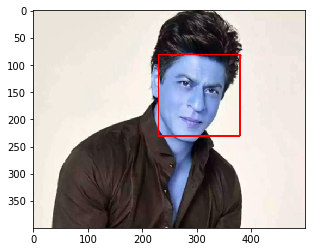

In [5]:
image = cv2.imread("celebs/srk.jpg")
image = cv2.resize(image, (500,400))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5,minSize=(50, 50))
for (x,y,w,h) in faces:
    img = cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = image[y:y+h, x:x+w]
    #cv2.imwrite('faces/'+str(w) + str(h) + '_faces.jpg', roi_color)
    plt.imshow(img)

In [6]:
for imgs in img_ls:
    image = cv2.imread("celebs/"+imgs)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5,minSize=(70, 70)) # Fine Tuning For all images
    for (x,y,w,h) in faces:
        img = cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]
        cv2.imwrite('celeb_faces/'+str(w) + str(h) + '_faces.jpg', roi_color)

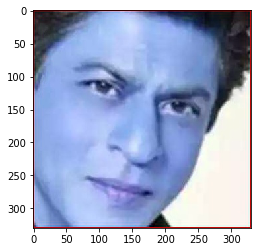

In [58]:
plt.imshow(cv2.imread("celeb_faces/srk1.jpg")) #images was renamed

## Importing FaceNet Model

In [7]:
FRmodel = faceRecoModel(input_shape=(3, 96, 96))

## Defing Triplet Loss Function

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example. 

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{m}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

Here, we are using the notation "$[z]_+$" to denote $max(z,0)$.  


In [8]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, we don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    
    # Computing the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    
    # Computing the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    
    # subtracting the two previous distances and adding alpha.
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    
    # Taking the maximum of basic_loss and 0.0. Summing over the exsisting training examples. 
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    
    return loss

## Loading the trained model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, we won't train it from scratch here. Instead, we load a previously trained model.

In [9]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

## Resizing the face Images

In [10]:
img_ls = os.listdir(os.path.join(cw,'celeb_faces'))
os.mkdir(os.path.join(cw,"celeb_resized"))

In [11]:
for i in img_ls:
    img = cv2.imread("celeb_faces/"+i)
    cv2.imwrite("celeb_resized/"+i, cv2.resize(img,(96,96)) )

**Note: We have to rename the images manually for preparing the embedding**

## Creating Dictionary of Embedding 

In [12]:
database = {}
database["hrithik"] = img_to_encoding("celeb_resized/hrithik2.jpg", FRmodel)
database["priyanka"] = img_to_encoding("celeb_resized/priyanka1.jpg", FRmodel)
database["SRK"] = img_to_encoding("celeb_resized/srk1.jpg", FRmodel)
database["ayushman"] = img_to_encoding("celeb_resized/ayushman.jpg", FRmodel)
database["katrina"] = img_to_encoding("celeb_resized/katrina.jpg", FRmodel)
database["varun"] = img_to_encoding("celeb_resized/varun.jpg", FRmodel)

In [45]:
database1 = {}
database1["hrithik"] = "celeb_resized/hrithik2.jpg"
database1["priyanka"] = "celeb_resized/priyanka1.jpg"
database1["SRK"] = "celeb_resized/srk1.jpg"
database1["ayushman"] = "celeb_resized/ayushman.jpg"
database1["katrina"] = "celeb_resized/katrina.jpg"
database1["varun"] = "celeb_resized/varun.jpg"

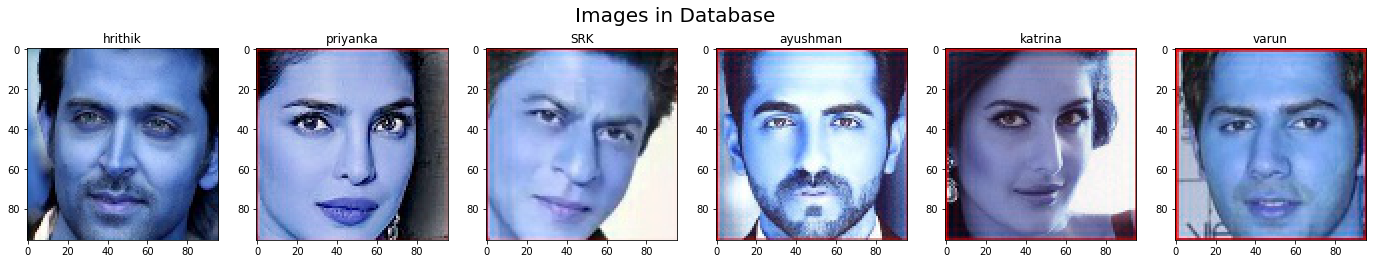

In [53]:
fig, ax = plt.subplots(1,6,figsize=(24,4))
axs = ax.ravel()

for i, celeb in enumerate(database1.keys()):
    axs[i].imshow(cv2.imread(database1[celeb]))
    axs[i].set_title(celeb)
plt.suptitle("Images in Database",fontsize=20)
plt.show()

In [34]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be a resident of the Happy house.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    
    """
    database1 = {}
    database1["hrithik"] = "celeb_resized/hrithik2.jpg"
    database1["priyanka"] = "celeb_resized/priyanka1.jpg"
    database1["SRK"] = "celeb_resized/srk1.jpg"
    database1["ayushman"] = "celeb_resized/ayushman.jpg"
    database1["katrina"] = "celeb_resized/katrina.jpg"
    database1["varun"] = "celeb_resized/varun.jpg"

    # Computing the encoding for the image.
    encoding = img_to_encoding(image_path, model)
    
    # Computing distance with identity's image
    dist = np.linalg.norm(database[identity] - encoding)
    
    # Verifing if dist < 0.7, else verification faliure!
    if dist < 0.7:
        print("Identity of " + str(identity) + " verified, Welcome!!")
        verification = True
    else:
        print("Verification of " + str(identity) + " failed!")
        verification = False
    fig, ax = plt.subplots(1,2, figsize = (10,5)) 
    axs = ax.ravel()
    axs[0].imshow(cv2.imread(database1[identity]))
    axs[0].set_title("Identity Card of "+identity+" used")
    axs[1].imshow(cv2.imread(image_path))
    axs[1].set_title("Image Caputred")
    return dist, verification

Verification of SRK failed!


(0.7785316, False)

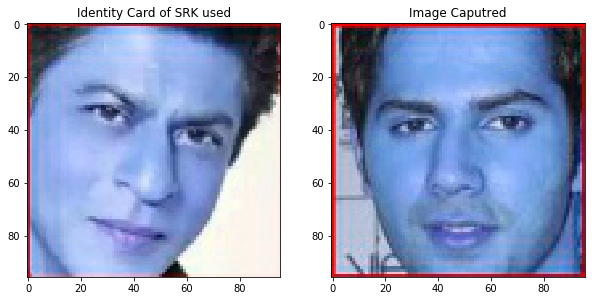

In [35]:
verify("celeb_resized/varun.jpg", "SRK", database, FRmodel)

Identity of varun verified, Welcome!!


(0.6167918, True)

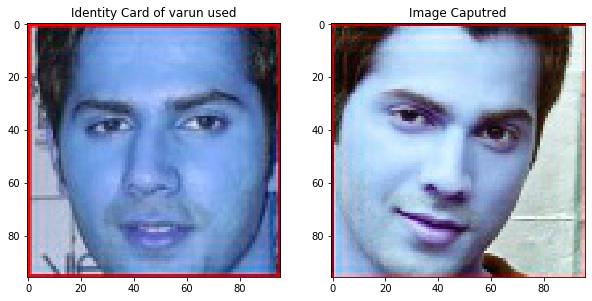

In [36]:
verify("celeb_resized/varun1.jpg", "varun", database, FRmodel)

Verification of priyanka failed!


(0.7448529, False)

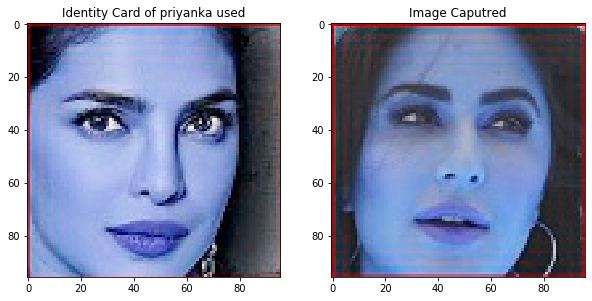

In [40]:
verify("celeb_resized/katrina1.jpg", "priyanka", database, FRmodel)

## Face Recognition

In [42]:
def face_recoginition(image_path, database, model):
    """
    Implements face recognition for the happy house by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    # Computing the target "encoding" for the image
    encoding = img_to_encoding(image_path, model)
    
    # Finding the closest encoding #
    
    # Initialize "min_dist" to a large value, say 100
    min_dist = 100
    
    # Looping over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database.
        dist = np.linalg.norm(db_enc - encoding)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name.
        if dist < min_dist:
            min_dist = dist
            identity = name

    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("It's " + str(identity))
        
    return min_dist, identity

In [43]:
face_recoginition("celeb_resized/ayushman1.jpg", database, FRmodel)

It's ayushman


(0.44931802, 'ayushman')